The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
import pickle

%matplotlib inline

In [2]:
CAMERA_CAL_PATH = './camera_cal'
EXAMPLES_PATH = './examples'
OUTPUT_PATH = './output_images'
TEST_PATH = './test_images'
PROJECT_VIDEO_PATH = './project_video.mp4'
CHALLENGE_VIDEO_PATH = './challenge_video.mp4'
HARDER_CHALLENGE_VIDEO_PATH = './harder_challenge_video.mp4'

### Undistort calibration images

./camera_cal/calibration13.jpg


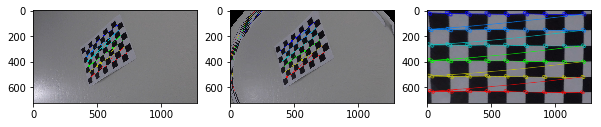

./camera_cal/calibration15.jpg


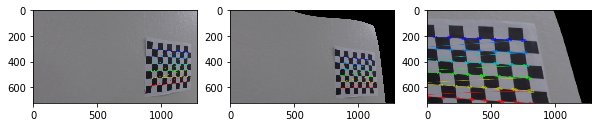

./camera_cal/calibration19.jpg


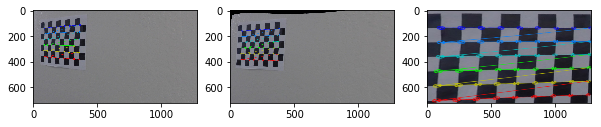

./camera_cal/calibration12.jpg


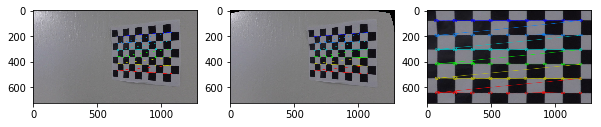

./camera_cal/calibration9.jpg


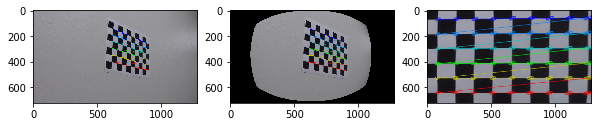

./camera_cal/calibration20.jpg


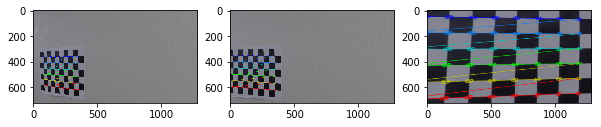

./camera_cal/calibration14.jpg


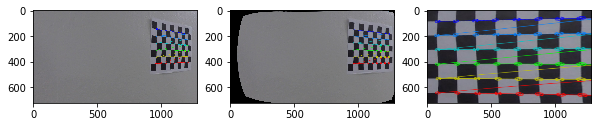

./camera_cal/calibration7.jpg


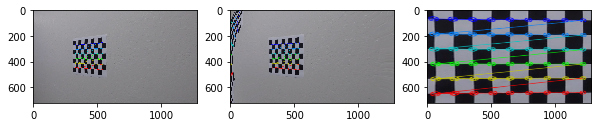

./camera_cal/calibration6.jpg


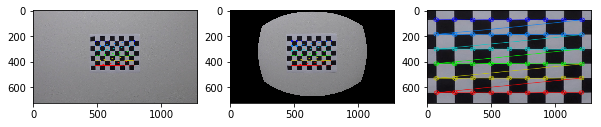

./camera_cal/calibration10.jpg


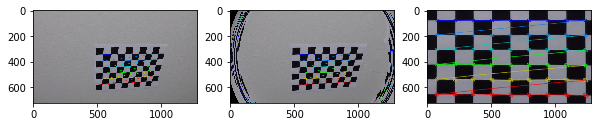

./camera_cal/calibration2.jpg


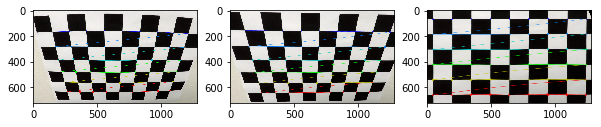

./camera_cal/calibration3.jpg


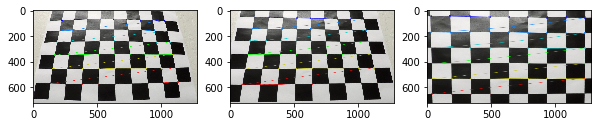

./camera_cal/calibration8.jpg


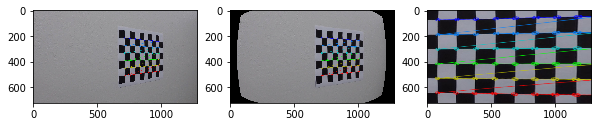

./camera_cal/calibration17.jpg


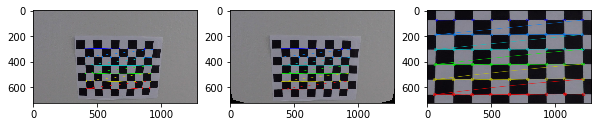

./camera_cal/calibration18.jpg


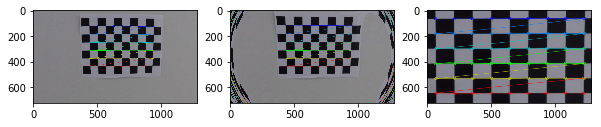

./camera_cal/calibration16.jpg


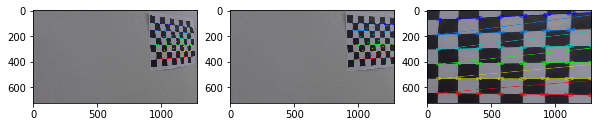

./camera_cal/calibration11.jpg


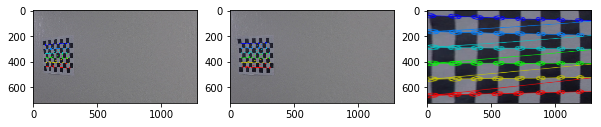

In [26]:
nx, ny = 9, 6
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

objpoints = []
objpoints.append(objp)
calibration_params = {}
calibration_img_paths = glob.glob(os.path.join(CAMERA_CAL_PATH, '*.jpg'))

for idx, img_path in enumerate(calibration_img_paths):
    img = mpimg.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    undist = img
    warped = img
    imgpoints = []
    # If found, draw corners
    if ret == True:
        f, ax = plt.subplots(1, 3, figsize=(10, 10))
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])            
        dst = np.float32([[80,80],[1200,80],[1200,640],[80,640]])
            
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        calibration_params[img_path] = [mtx, dist, rvecs, tvecs, M, Minv]
        
        print(img_path)
        ax[0].imshow(img)
        ax[1].imshow(undist)
        ax[2].imshow(warped)
        plt.show()
pickle.dump(calibration_params, open( "calibraiton_params.p", "wb" ) )

### Undistort first test image with each calibration image

In [ ]:
test_img_paths = glob.glob(os.path.join(TEST_PATH, '*.jpg'))

for img_path, params in calibration_params.items():
    print(img_path)
    [mtx, dist, rvecs, tvecs, M, Minv] = calibration_params[img_path]
    
    for idx, test_img_path in enumerate(test_img_paths):
        print(test_img_path)
        f, ax = plt.subplots(1, 2, figsize=(20, 15))
        test_img = mpimg.imread(test_img_path)
        undist = cv2.undistort(test_img, mtx, dist, None, mtx)
        ax[0].imshow(test_img)
        ax[1].imshow(undist)
        
    plt.show()

Looking at results of undistortion, it appears that calibration images 2,3,20 are good candidates for undistortion. Going to use undistortion matrix and coefficients from calibration2 for the rest of the pipeline.

In [46]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient == 'x'), int(orient == 'y'))
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_mask = np.zeros_like(scaled_sobel)
    binary_mask[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_mask

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad > thresh[0]) & (dir_grad < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def hls_select(img, channel='s', thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    if channel == 'h':
        c = hls[:,:,0]
    elif channel == 'l':
        c = hls[:,:,1]
    else:
        c = hls[:,:,2]
    binary_output = np.zeros((hls.shape[0], hls.shape[1]))
    binary_output[(c > thresh[0]) & (c <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

### Applying gradient based thresholding

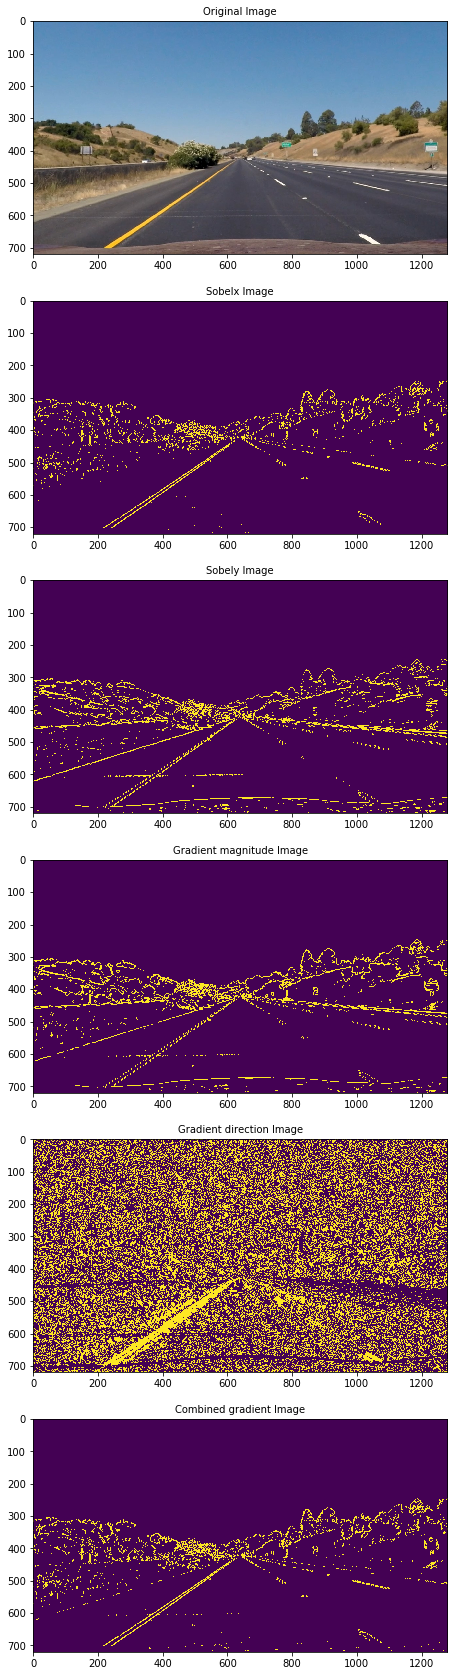

In [64]:
test_img_path = './test_images/straight_lines1.jpg'
test_img = mpimg.imread(test_img_path)
[mtx, dist, rvecs, tvecs, M, Minv] = calibration_params['./camera_cal/calibration2.jpg']
undist = cv2.undistort(test_img, mtx, dist, None, mtx)

sobelx = abs_sobel_thresh(undist, 'x', 25, 100)
sobely = abs_sobel_thresh(undist, 'y', 25, 100)
mag_binary = mag_thresh(undist, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.25))
combined = np.zeros_like(dir_binary)
combined[((sobelx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, ax = plt.subplots(6, 1, figsize=(50, 30))
ax[0].imshow(undist)
ax[0].set_title('Original Image', fontsize=10)
ax[1].imshow(sobelx)
ax[1].set_title('Sobelx Image', fontsize=10)
ax[2].imshow(sobely)
ax[2].set_title('Sobely Image', fontsize=10)
ax[3].imshow(mag_binary)
ax[3].set_title('Gradient magnitude Image', fontsize=10)
ax[4].imshow(dir_binary)
ax[4].set_title('Gradient direction Image', fontsize=10)
ax[5].imshow(combined)
ax[5].set_title('Combined gradient Image', fontsize=10)

### Applying color based thresholding

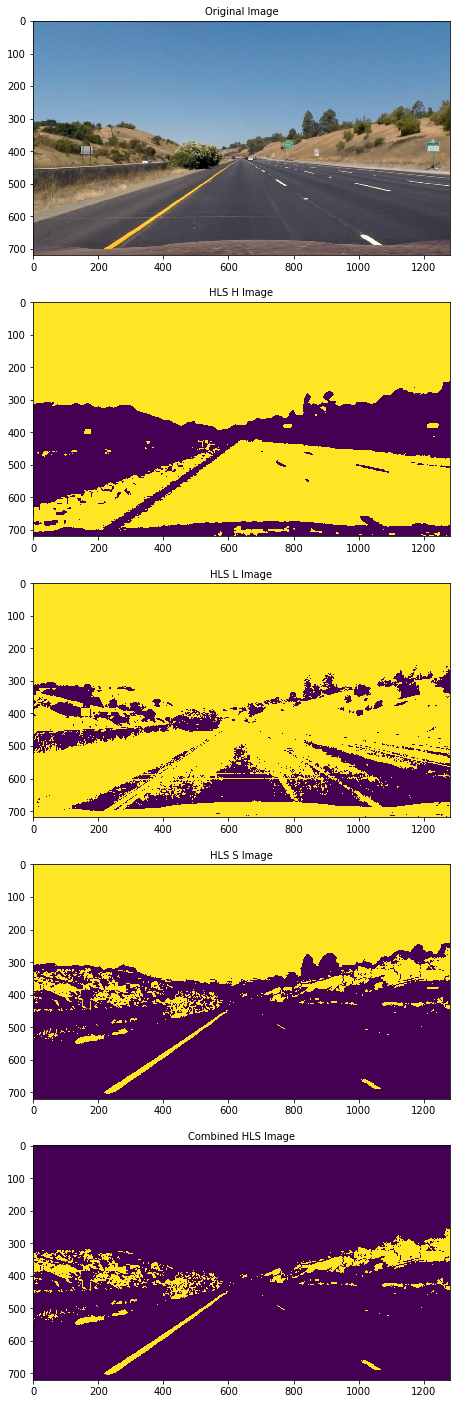

In [67]:
h_binary = hls_select(undist, channel='h', thresh=(75, 255))
l_binary = hls_select(undist, channel='l', thresh=(75, 255))
s_binary = hls_select(undist, channel='s', thresh=(75, 255))
hls_binary = np.zeros_like(dir_binary)
hls_binary[((s_binary == 1) & (h_binary == 0))] = 1

f, ax = plt.subplots(5, 1, figsize=(40, 25))
ax[0].imshow(undist)
ax[0].set_title('Original Image', fontsize=10)
ax[1].imshow(h_binary)
ax[1].set_title('HLS H Image', fontsize=10)
ax[2].imshow(l_binary)
ax[2].set_title('HLS L Image', fontsize=10)
ax[3].imshow(s_binary)
ax[3].set_title('HLS S Image', fontsize=10)
ax[4].imshow(hls_binary)
ax[4].set_title('Combined HLS Image', fontsize=10)

### Combining gradient and color thresholding

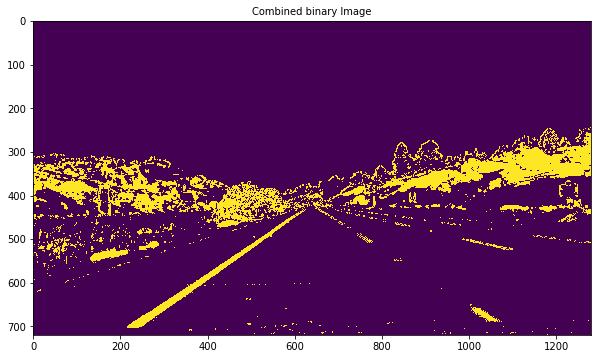

In [68]:
combined_binary = np.zeros_like(combined)
combined_binary[(combined == 1) | (hls_binary == 1)] = 1

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(combined_binary)
ax.set_title('Combined binary Image', fontsize=10)

### Perspective Transform